In [ ]:
import os
import zipfile
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Paths
zip_path = '/content/drive/MyDrive/Liver_Dataset/archive (1).zip'
output_path = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/'
image_dir = os.path.join(output_path, 'images')
mask_dir = os.path.join(output_path, 'masks')

# Create directories
os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# 1. Extract dataset.zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('unzipped_data')

volume_path = 'unzipped_data/volume_pt3'
seg_path = 'unzipped_data/segmentations'

# 2. Preprocessing and Slicing
def normalize_ct(img):
    img = np.clip(img, -200, 250)
    img = (img + 200) / 450.0  # Scale to [0,1]
    return img

slice_count = 0
for filename in tqdm(os.listdir(volume_path)):
    if not filename.endswith('.nii') and not filename.endswith('.nii.gz'):
        continue

    volume_file = os.path.join(volume_path, filename)
    seg_file = os.path.join(seg_path, filename.replace('volume', 'segmentation'))

    volume = nib.load(volume_file).get_fdata()
    mask = nib.load(seg_file).get_fdata()

    volume = normalize_ct(volume)
    volume = volume.astype(np.float32)
    mask = mask.astype(np.uint8)

    for i in range(volume.shape[2]):  # Iterate over slices
        img_slice = volume[:, :, i]
        mask_slice = mask[:, :, i]

        if np.max(mask_slice) == 0:  # Skip empty slices
            continue

        # Resize to 256x256 (optional)
        img_resized = cv2.resize(img_slice, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Save images and masks
        img_filename = os.path.join(image_dir, f"img_{slice_count:05d}.png")
        mask_filename = os.path.join(mask_dir, f"mask_{slice_count:05d}.png")

        # Scale image to [0, 255] for saving
        img_uint8 = (img_resized * 255).astype(np.uint8)
        cv2.imwrite(img_filename, img_uint8)
        cv2.imwrite(mask_filename, mask_resized)

        slice_count += 1

print(f"✅ Saved {slice_count} image-mask pairs.")


100%|██████████| 10/10 [01:09<00:00,  6.93s/it]

✅ Saved 1443 image-mask pairs.


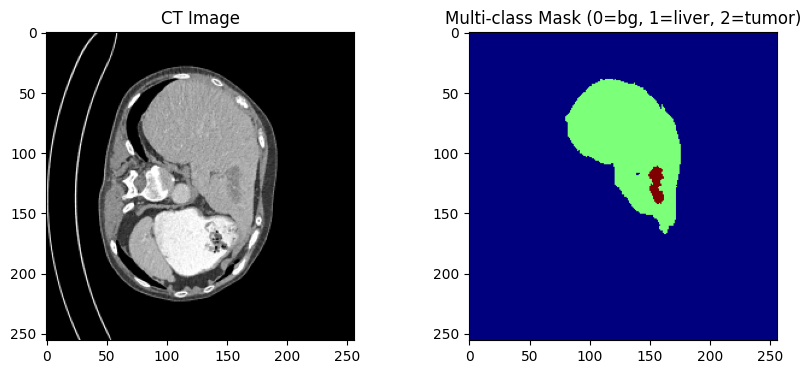

In [ ]:
# 3. Show a sample image and mask
sample_img = cv2.imread(os.path.join(image_dir, 'img_01016.png'), cv2.IMREAD_GRAYSCALE)
sample_mask = cv2.imread(os.path.join(mask_dir, 'mask_01016.png'), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title('CT Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='jet', vmin=0, vmax=2)
plt.title('Multi-class Mask (0=bg, 1=liver, 2=tumor)')
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil

src_img_dir = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/images'
src_mask_dir = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/masks'

dst_img_dir = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/tri_class/images'
dst_mask_dir = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/tri_class/masks'

os.makedirs(dst_img_dir, exist_ok=True)
os.makedirs(dst_mask_dir, exist_ok=True)

count = 0
for filename in tqdm(sorted(os.listdir(src_mask_dir))):
    if not filename.endswith('.png'):
        continue

    mask_path = os.path.join(src_mask_dir, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if all 3 classes are present
    unique_classes = np.unique(mask)
    if all(x in unique_classes for x in [0, 1, 2]):
        # Copy both image and mask to new folder
        img_path = os.path.join(src_img_dir, filename.replace('mask', 'img'))
        shutil.copy(img_path, os.path.join(dst_img_dir, os.path.basename(img_path)))
        shutil.copy(mask_path, os.path.join(dst_mask_dir, filename))
        count += 1

print(f"✅ Saved {count} tri-class image-mask pairs to 'tri_class' folder.")


100%|██████████| 1443/1443 [00:33<00:00, 43.03it/s] 

✅ Saved 472 tri-class image-mask pairs to 'tri_class' folder.


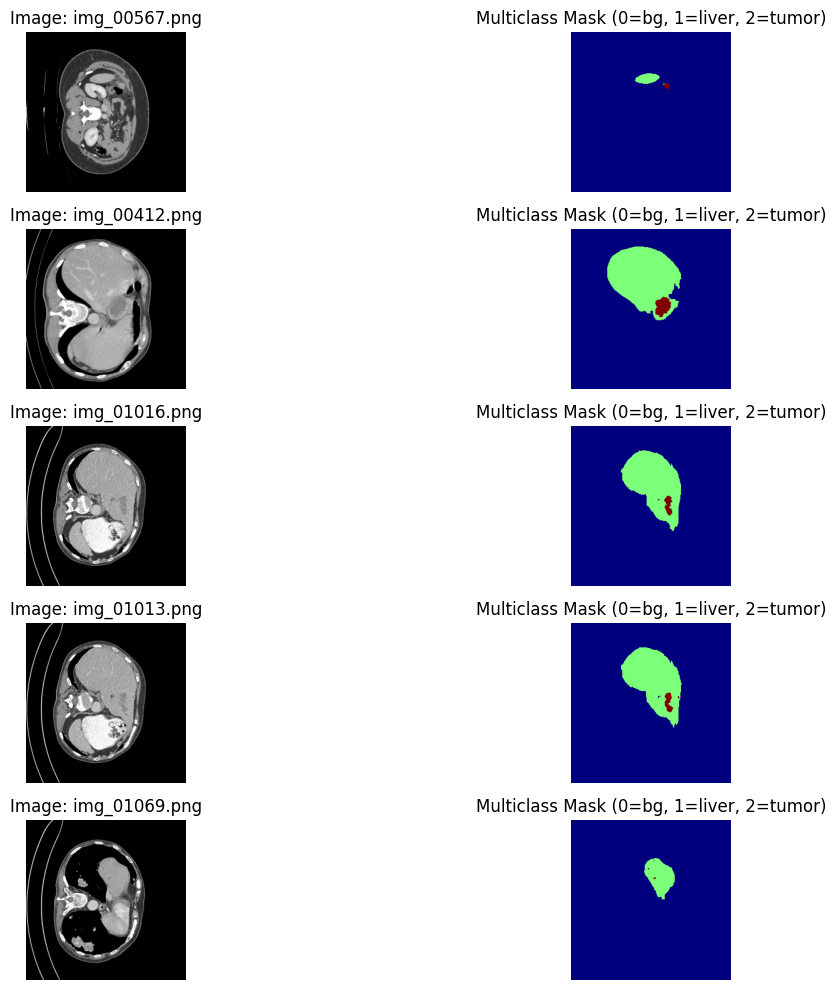

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Paths
image_dir = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/tri_class/images'
mask_dir = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/tri_class/masks'

# List all image filenames
image_files = sorted(os.listdir(image_dir))
sample_files = random.sample(image_files, min(5, len(image_files)))  # View up to 5 random samples

# Plot
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(sample_files):
    # Load image and mask
    img = cv2.imread(os.path.join(image_dir, img_file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(mask_dir, img_file.replace('img', 'mask')), cv2.IMREAD_GRAYSCALE)

    # Plot image
    plt.subplot(len(sample_files), 2, 2*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Image: {img_file}')
    plt.axis('off')

    # Plot mask with colormap
    plt.subplot(len(sample_files), 2, 2*i + 2)
    plt.imshow(mask, cmap='jet', vmin=0, vmax=2)
    plt.title('Multiclass Mask (0=bg, 1=liver, 2=tumor)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil

# === Paths ===
dataset1_images = "/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/tri_class/images"
dataset1_masks = "/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3/tri_class/masks"
dataset2_images = "/content/drive/MyDrive/Liver_Dataset/LiTS_processed_4/tri_class/images"
dataset2_masks = "/content/drive/MyDrive/Liver_Dataset/LiTS_processed_4/tri_class/masks"

merged_images = "/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3_4/tri_class/images"
merged_masks = "/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3_4/tri_class/masks"

# === Create destination folders if not exist ===
os.makedirs(merged_images, exist_ok=True)
os.makedirs(merged_masks, exist_ok=True)

# === Helper function to rename and copy files ===
def rename_and_copy(src_folder, dst_folder, tag):
    for filename in os.listdir(src_folder):
        name, ext = os.path.splitext(filename)
        new_name = f"{name}_{tag}{ext}"
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, new_name)
        shutil.copy(src_path, dst_path)

# === Rename and merge ===
rename_and_copy(dataset1_images, merged_images, "pt3")
rename_and_copy(dataset1_masks, merged_masks, "pt3")
rename_and_copy(dataset2_images, merged_images, "pt4")
rename_and_copy(dataset2_masks, merged_masks, "pt4")

print("Renaming and merging complete.")


Renaming and merging complete.


In [ ]:
import os

# Set the path to your folder
folder_path = '/content/drive/MyDrive/Liver_Dataset/LiTS_processed_3_4/tri_class/masks'

# Count number of files (e.g., images)
image_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
print(f"Total images in {folder_path}: {image_count}")


Total images in /content/drive/MyDrive/Liver_Dataset/LiTS_processed_3_4/tri_class/masks: 818
